# Part 2 

## Investigating patterns of TR variation

This section focuses on Use case 1 described in the paper on investigating TR heterozygosity and allele distribution.

Code used in this notebook is adapted from the codebase that is available here https://github.com/gymreklab/1000Genomes-TR-Analysis

In [1]:
# required software
!bash check_software.sh bcftools statSTR | grep "NOT installed"

In [2]:
# directory for output
!mkdir downstream

In [3]:
# get chrom,pos,period and repeat unit
!bcftools query -f"%CHROM\t%POS\t%INFO/PERIOD\t%INFO/RU\n" output/ensembletr_output/ensembletr.vcf.gz > downstream/motif_info.tab
!cat downstream/motif_info.tab

chr1	77887913	3	AAG
chr11	57528484	2	AT
chr14	64253561	2	AC
chr17	51831668	3	AGC
chr21	43776443	12	CCCCGCCCCGCG
chr4	3074877	3	AGC
chr4	3074940	3	CCG


In [4]:
# import libraries
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import os
import pandas as pd
import scipy.stats
import seaborn as sns

### Distribution of the fraction of non-reference alleles in individuals by super population

In the cell below variants from each population to a Python script that counts the number of reference  and non-reference alleles for each sample. It returns a file with three columns sample, reference allele count and non-reference count

In [12]:
%%bash 

populations=("africa" "europe" "east_asia" "south_asia" "america")

for population in "${populations[@]}"; do

    bcftools view -S str_resources/"${population}"_ids.csv output/ensembletr_output/ensembletr.vcf.gz \
        | python3 qc.py "${population}"

done

defaultdict(<class 'int'>, {'HG02481': 2, 'HG02108': 2, 'NA19153': 3, 'HG03458': 1, 'HG03436': 2, 'NA20287': 1, 'HG03073': 2, 'HG02343': 2, 'NA18523': 2, 'NA19247': 3, 'HG02851': 3, 'NA20357': 1, 'NA19455': 1, 'HG03209': 2, 'HG03190': 1, 'HG03291': 1, 'HG02554': 2, 'NA20332': 1, 'NA20296': 1, 'HG02095': 1, 'HG03115': 2, 'HG02484': 1, 'HG02595': 1, 'HG03040': 1, 'HG02439': 1, 'NA20351': 1, 'HG02757': 1, 'NA19312': 1, 'HG02322': 2, 'NA19159': 1, 'HG03539': 2, 'NA19332': 1, 'HG03432': 2, 'NA19256': 1})
defaultdict(<class 'int'>, {'NA20762': 2, 'NA20522': 2, 'HG00334': 1, 'HG00284': 2, 'HG00242': 2, 'HG00237': 4, 'HG00136': 2, 'HG01777': 5, 'HG00108': 4, 'NA20767': 1, 'NA12144': 4, 'HG00306': 3, 'NA12414': 2, 'HG01668': 4, 'NA20519': 2, 'HG02232': 3, 'NA12155': 2, 'NA12760': 2, 'NA20510': 2, 'HG00304': 1, 'HG00313': 1, 'HG00260': 2, 'HG00336': 4, 'HG00133': 1, 'HG01632': 3, 'HG00157': 1, 'HG01770': 3, 'HG00155': 2, 'HG01507': 2, 'HG00353': 2, 'HG00142': 2, 'NA07347': 3, 'NA12828': 2, 'NA20

defaultdict(<class 'int'>, {'HG00698': 2, 'HG01873': 2, 'NA18749': 4, 'NA18748': 3, 'NA18945': 3, 'NA18537': 2, 'NA18642': 3, 'HG01870': 2, 'HG01598': 2, 'HG02017': 3, 'HG00651': 2, 'HG01855': 1, 'NA18982': 3, 'HG02121': 3, 'HG02396': 2, 'NA18539': 1, 'NA18609': 1, 'HG00437': 2, 'HG00513': 2, 'HG02394': 2, 'NA18571': 2, 'NA19011': 1, 'NA19075': 2, 'HG02390': 2, 'HG02122': 2, 'NA18636': 1, 'HG00500': 2, 'HG00663': 1, 'NA18547': 1, 'HG02023': 1, 'NA18961': 1, 'NA18980': 1, 'NA18979': 1, 'HG02407': 1, 'NA18622': 2, 'HG00690': 2, 'NA18573': 2, 'HG00707': 1, 'HG00610': 1, 'HG02380': 2, 'NA19007': 1})
defaultdict(<class 'int'>, {'HG03022': 1, 'HG03615': 2, 'HG03738': 2, 'HG04039': 3, 'NA21133': 1, 'NA21088': 2, 'HG03631': 4, 'HG03905': 4, 'HG04140': 3, 'HG03885': 2, 'HG03895': 3, 'HG03706': 3, 'HG03773': 3, 'HG03920': 2, 'NA21112': 2, 'HG03646': 1, 'HG04227': 2, 'HG04153': 3, 'HG03894': 2, 'HG03971': 2, 'NA20905': 1, 'NA20910': 2, 'HG04014': 1, 'NA21118': 1, 'HG02793': 2, 'HG03770': 2, 'HG03

The code below calculates the proportion of non-reference alleles for each super population. 

Boxplots summarize the distribution of the fraction of variant alleles. Horizontal lines show median values, boxes span from the 25th percentile (Q1) to the 75th percentile (Q3). Whiskers extend to Q1–1.5IQR (bottom) and Q3 + 1.5IQR (top), where IQR gives the interquartile range (Q3-Q1).

In [13]:
super_populations = ["africa", "europe", "east_asia", "south_asia", "america"]

df = pd.DataFrame(columns = super_populations)

for pop in super_populations:

    var_data_whole = pd.DataFrame(columns = ['Sample', 'ref', 'non_ref'])

    var_data = pd.read_csv(f"{pop}_no_homo.txt", delimiter="\t", header=None)
    var_data.columns = ['Sample', 'ref_chr', 'non_ref_chr']

    if len(var_data_whole) == 0:
        var_data_whole = var_data.copy()
        var_data_whole.columns = ['Sample', 'ref', 'non_ref']

    else:

        var_data_whole = pd.merge(var_data_whole,var_data, on = "Sample")
        var_data_whole['ref'] = var_data_whole['ref'] + var_data_whole['ref_chr']
        var_data_whole['non_ref'] = var_data_whole['non_ref'] + var_data_whole['non_ref_chr']
        var_data_whole = var_data_whole.drop(columns = ['ref_chr', 'non_ref_chr'])

    df[pop] = var_data_whole['non_ref'] / (var_data_whole['ref'] + var_data_whole['non_ref'])


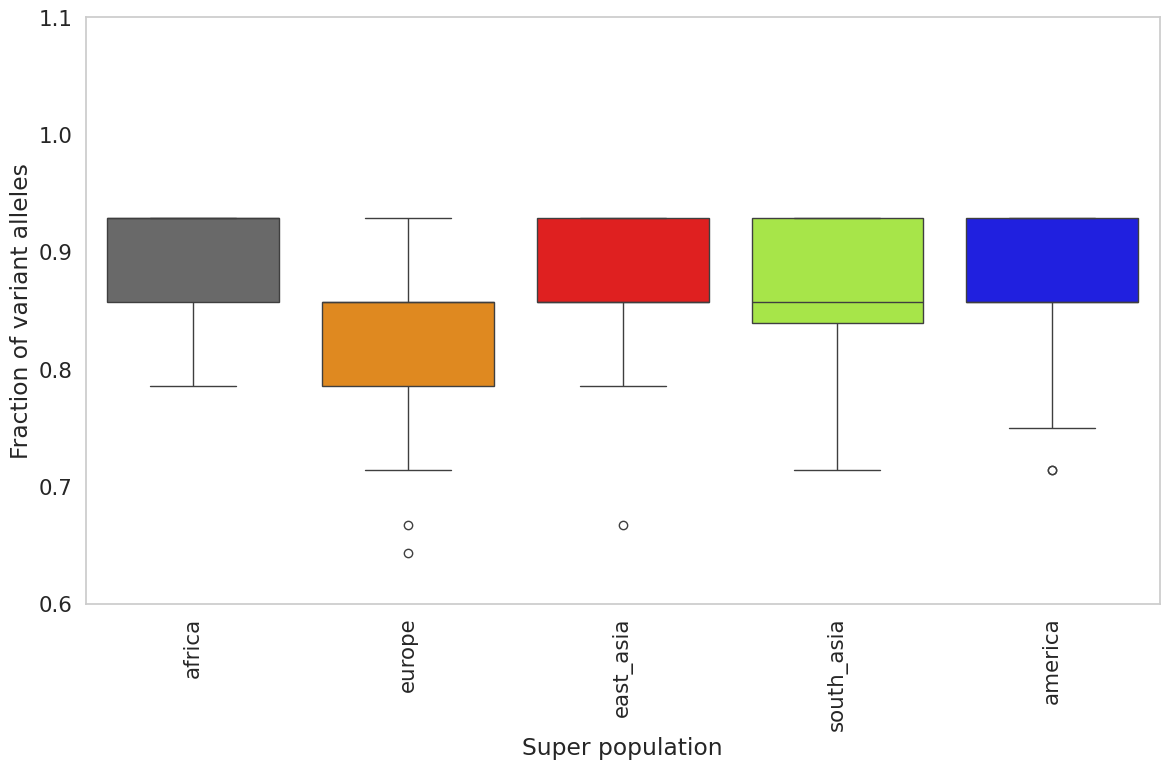

In [14]:
colors = ["dimgrey", "darkorange", "red", "greenyellow", "blue", "purple"]

color_dict = dict(zip(super_populations, colors))
sns.set(rc={'figure.figsize':(12,8)},font_scale = 1.4)
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(data=df, palette=color_dict)
ax.set(xlabel='Super population', ylabel='Fraction of variant alleles')
ax.set_ylim(0.6,1.1)

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("downstream/fraction_of_variant-alleles.pdf", dpi=1200)

### Population-specific allele distributions

In the next code cells, we investigate the distribution of TR lengths of variant alleles for all super populations

In [19]:
!bash statSTR_pop_stats.sh africa europe east_asia south_asia america


Done

Done

Done

Done

Done


In [23]:
# For each sample, count how many alleles match ref, ref+1, ref-1, etc.
# Do separately for homopolymers and non-homopolymers
!python summarize_allele_sizes.py output/ensembletr_output/ensembletr.vcf.gz > downstream/asize_summary.tab

/home/ibra/protocol/genotyping_repeats_tutorial/summarize_allele_sizes.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["Superpopulation"] = samples["Superpopulation"].apply(GetPopOrder)
Reading records
HG03615
HG02375
NA21088
HG03685
NA18749
HG00285
HG00111
HG03995
HG02364
NA19785
HG00739
HG02484
NA18748
HG03114
HG02595
HG03432
NA20522
HG01965
NA19663
HG01797
HG02343
HG01923
HG02143
HG02275
HG02651
HG03040
HG00233
NA21112
HG00698
HG04153
HG00262
NA19430
HG03787
HG01083
HG02121
HG03631
HG02580
HG03115
NA19780
HG00108
HG00136
HG01374
NA19794
NA19011
HG03866
HG01325
HG03773
HG03781
NA18982
NA20519
HG01507
NA18609
HG03291
HG03895
NA21126
NA20534
HG02407
HG00472
HG02793
HG03643
HG01095
HG00379
HG00707
HG01136
HG03022
HG02643
HG02180
HG012

In [24]:
####### Set up #########
def GetSuperpopColors(spop):
    if "Europe" in spop: return "blue"
    if "Africa" in spop: return "gold"
    if "America" in spop: return "red"
    if "East Asia" in spop: return "green"
    if "South Asia" in spop: return "purple"


/tmp/ipykernel_3264/136596395.py:11: FutureWarning: The provided callable <function sum at 0x7ff8a85c5b20> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby(["spop","type"], as_index=False).agg(aggdict)
/tmp/ipykernel_3264/136596395.py:11: FutureWarning: The provided callable <function sum at 0x7ff8a85c5b20> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby(["spop","type"], as_index=False).agg(aggdict)


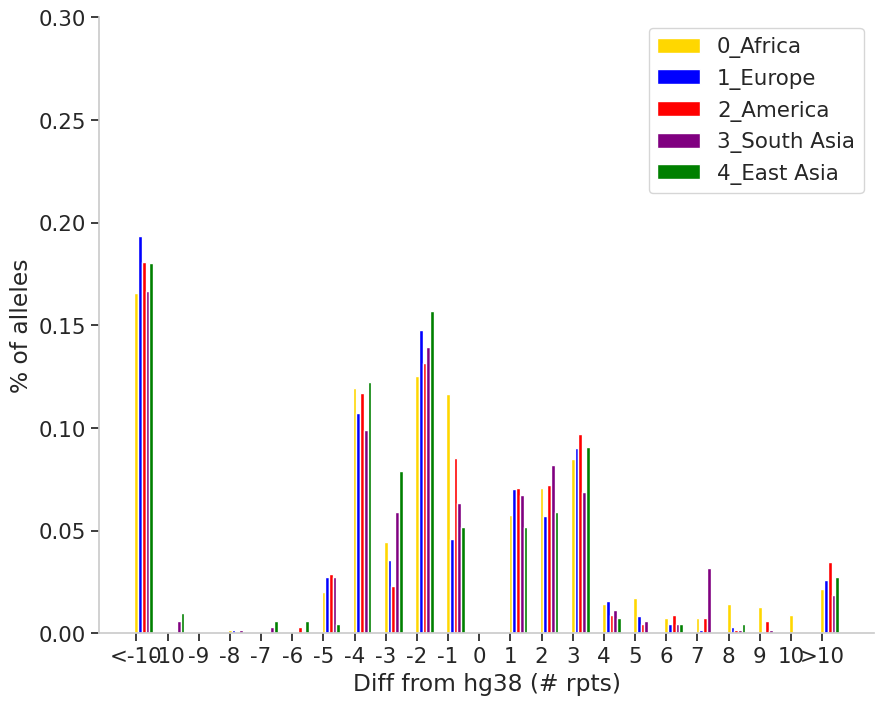

In [28]:
# Load data, sum across all chromosomes
# data gives counts of allele sizes in each sample,
# separately for homopolymers/non-homopolymers

sizecols = list(range(-11, 12))
data = pd.read_csv("downstream/asize_summary.tab", sep="\t", names=["sample","spop","pop","type"] + sizecols)

# Aggregate by summarizing across samples/chromosomes
aggdict = {}
for i in sizecols: aggdict[i] = np.sum
data = data.groupby(["spop","type"], as_index=False).agg(aggdict)

w = 0.12
vtype = "other"

byspop = data[data["type"]==vtype].copy()
byspop.index = byspop["spop"]
byspop = byspop.drop(columns = ["spop","type"])
byspop = byspop.div(byspop.sum(axis=1), axis=0)
byspop[0] = np.nan

fig = plt.figure()
fig.set_size_inches((10, 8))
ax = fig.add_subplot(111)
i = 0
for spop in sorted(list(byspop.index)):
    vals = byspop.loc[spop]
    color = GetSuperpopColors(spop)
    ax.bar([item+w*i for item in sizecols], vals, color=color, label=spop, width=w)
    i += 1
ax.legend(loc="upper right")
ax.set_xticks(sizecols)
ax.set_xticklabels(["<-10"]+list(range(-10, 11)) + [">10"])
ax.set_xlabel("Diff from hg38 (# rpts)")
ax.set_ylabel("% of alleles")
ax.set_ylim(bottom=0, top=0.3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

figname = "DiffFromRef-Nonhomopolymer.pdf"
fig.savefig(os.path.join("downstream", figname))

Now, we zoom into some loci to investigate population-specific allele distributions. The x-axis denotes the allele length (number of repeats relative to hg38) and the y-axis denotes the frequency of each allele under investigation.

In [32]:
%%bash

bash statSTR_loci_stats.sh 4 3074877

bash statSTR_loci_stats.sh 11 57528484

bash statSTR_loci_stats.sh 14 64253561

bash statSTR_loci_stats.sh 17 51831668


Done

Done

Done

Done

Done

Done


In [33]:
def GetRowColors(spop):
    if "europe" in spop: return "blue"
    if "africa" in spop: return "gold"
    if "america" in spop: return "red"
    if "east_asia" in spop: return "green"
    if "south_asia" in spop: return "purple"

def plot_locus_allele_distribution(filepath = str):

    data = pd.read_csv(filepath_or_buffer = filepath, sep="\t")

    if data.shape[0] != 1:
        assert("Need to find exactly one locus!")

    fig = plt.figure()
    fig.set_size_inches((8, 8))
    popnum = 0
    w = 0.15

    for pop in ["africa", "europe", "east_asia", "south_asia", "america"]:

        ax = fig.add_subplot(6, 1, popnum+1)
        vals = data["afreq-%s"%pop].values[0]
        xvals = []
        yvals = []
        for ainfo in vals.split(","):
            allele, freq = ainfo.split(":")
            allele = int(float(allele))
            freq = float(freq)
            xvals.append(allele)
            yvals.append(freq)
        ax.bar(xvals, yvals, color=GetRowColors(pop), edgecolor="black", label=pop, width=1)
        ax.legend(loc="upper right")
        popnum += 1
        ax.set_xlim(left=0, right=80)
        
    ax.legend(loc="upper right");
    ax.set_xlabel("Allele length")
    ax.set_ylabel("Frequency");


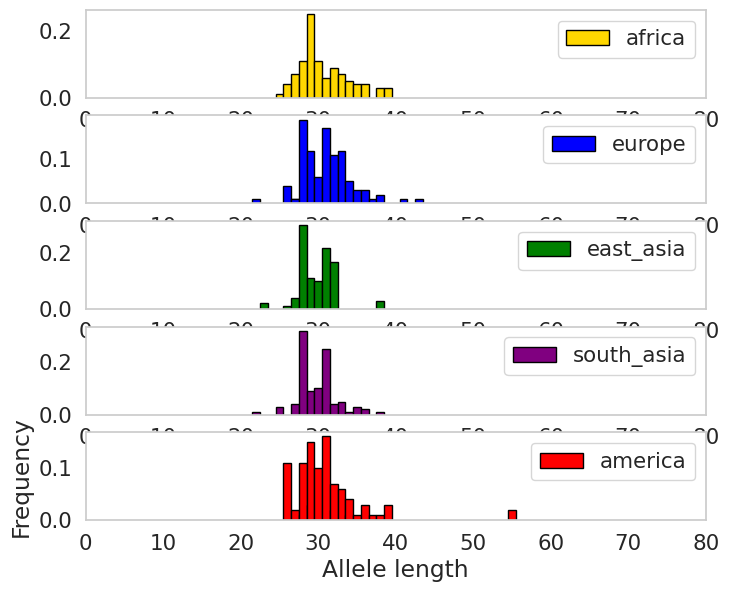

In [34]:
plot_locus_allele_distribution("downstream/chr4.3074877_stats.tab")

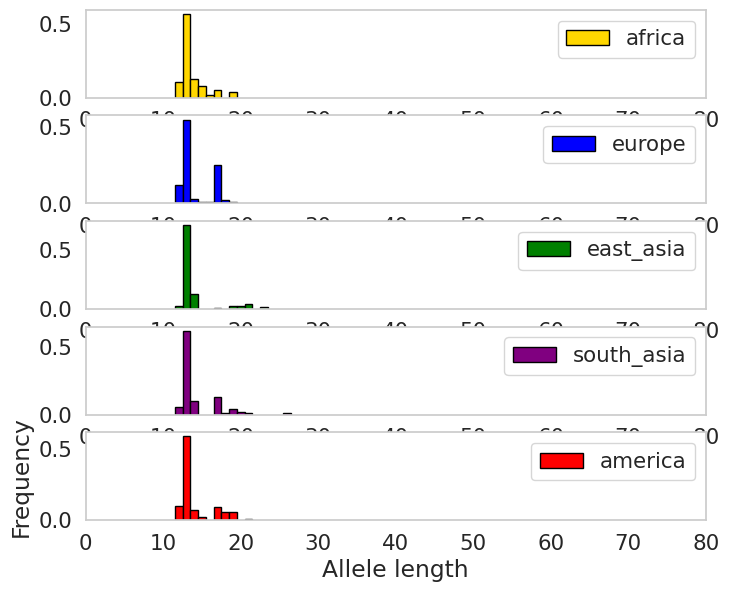

In [36]:
plot_locus_allele_distribution("downstream/chr11.57528484_stats.tab")

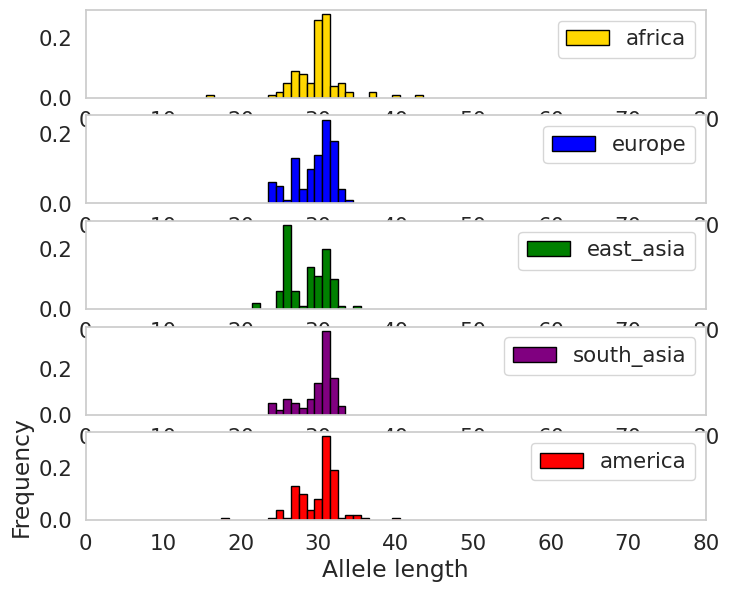

In [37]:
plot_locus_allele_distribution("downstream/chr14.64253561_stats.tab")

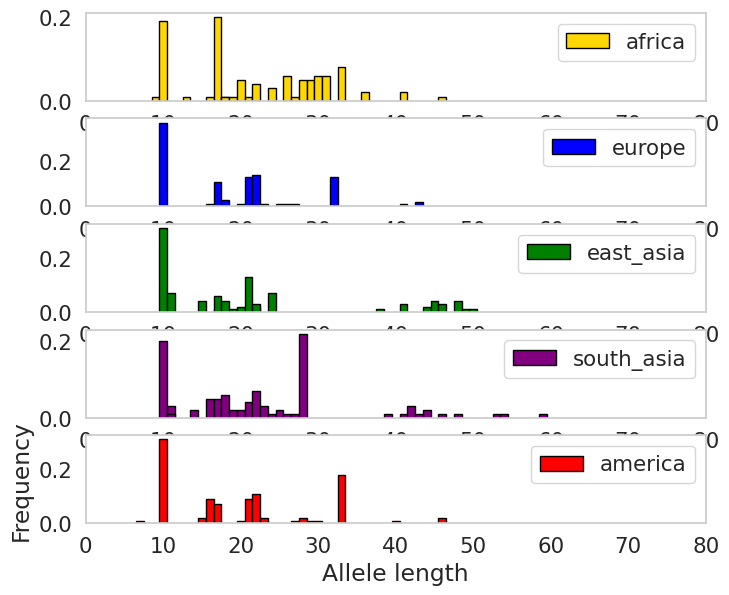

In [38]:
plot_locus_allele_distribution("downstream/chr17.51831668_stats.tab")

## Identifying associations between STRs and comples traits with associaTR

In this example, we use the example dataset in TRTools to demostrate how to performs association analysis between STRs and a trait under investigation

In [40]:
!associaTR --help

usage: associaTR [-h] [--vcftype {eh,hipstr,gangstr,popstr,advntr}]
                 [--same-samples] [--sample-list SAMPLE_LIST]
                 [--region REGION] [--non-major-cutoff NON_MAJOR_CUTOFF]
                 [--beagle-dosages] [--version]
                 outfile tr_vcf phenotype_name traits [traits ...]

positional arguments:
  outfile
  tr_vcf
  phenotype_name        name of the phenotype being regressed against
  traits                At least one (possibly more) .npy 2d float array
                        files, containing trait values for samples. The first
                        trait from the first file is the phenotype to be
                        regressed against, all other traits from that file are
                        used as covariates. Additional files can be listed to
                        add additional covariates. If --same-samples is not
                        specified, the first column of each file must be the
                        numeric samp

In [ ]:
# converting phenotype to .npy file 

In [ ]:
%% bash
associaTR \
    association_results.tsv \
    output/ensembletr_output/ensembletr.vcf.gz \
    gene_expression \
    gene_expression.npy \
    --vcftype hipstr \
    --sample-list \
    --region chr14:start-end 

In [ ]:
# visualisation of results